# Our Lovely Notebook on Toy Models
Motivate looking into toy models in the context of the study group. We desire to gain insight into: 
- frequency response of a mechanical systems; 
- observability of mechanical systems with hidden variables; 

Motivate Julia as alternative for Matlab (adjoint sensitivity, automatic differentiation for Jacobians, symbolic and numerical computations under the same hood). 

This notebook is structured as follows: 
- classical single mass spring damper;
- two coupled point masses coupled by springs and dampers such that variables attached to second point mass act as hidden variables;  

## Import Libraries

In [5]:
using ControlSystems 
using Plots

## Section 1: Single Mass-Damper-Spring  
In this section, we study a single mass-damper-spring mechanism. The mass $m$ is assumed to be attached to a wall with spring having spring constant $k$ and damper with damping constant $d$. We assume that the mass can be determined a-priori using a scale. Our goal here is to:  
- define second order ODE as equation of motion;
- define state-space representation;
- define transfer function and plot Bode diagram (see e.g. [wikipedia on Bode diagram](https://en.wikipedia.org/wiki/Bode_plot)) and explore various frequency ranges to determine the spring constant $k$ andf the damping parameter $d$. This will motivated a multi-stage optimization approach;   
- plot Nyquist diagram (see e.g. [wikipedia on Nyquist diagram](https://en.wikipedia.org/wiki/Nyquist_stability_criterion#Nyquist_plot)) and explore the use of the Nyquist plot as alternative to define the mismatch (or dispancy between measured and simulated data); 

### Time-Domain Representation
Denote $x(t)$ position and $\dot{x}(t)$ speed at time $t$. Then equation of motion becomes  
$$ m \, \ddot{x}(t) + d \, \dot{x}(t) + k \, x(t) = F(t)$$
supplied with initial conditions. 

(put here example of time integration, direct sensitivity, least-squares along trajectory)

### State Space Representation 
State-space representation
$ X = \begin{pmatrix} x \\ \dot{x} \end{pmatrix}$ 
$$ \dot{X} = A X + B u \\ y = C X + D u $$ 
where $A = \begin{pmatrix} 0 & 1 \\ -k/m & -d/m \end{pmatrix}$, 
$B = \begin{pmatrix} 0 \\ F_0 \end{pmatrix}$, 
$C = \begin{pmatrix} 0 & 1 \end{pmatrix}$ and $D=0$.    

### Convert to Frequency Domain and Plot
Graphs in frequency domain confirm that:
- in the limit that $\omega \rightarrow 0$ $H(\omega) = 1/k$. Thus at $\omega=0$, 
$\log( |H(\omega)| ) = \log(1/k)$. This limit thus allows to determine  the spring constant $k$; 
- in the limit that $\omega \rightarrow \infty$ $H(\omega) = 1/(m \, \omega^2)$. Thus in this limit $\log( |H(\omega)| ) = \log(1/(m) -2 \log( \omega )$. This limit should match with the value of $m$. The slope is 40 Db per decade (20 Db (due to units) times slope of 2);  
- the value of the damping coefficient can be determined from the value of $H(\omega)$ in the resonant frequency $\omega_0 = \sqrt{\frac{k}{m}}$; 

### Numerical Values for the y-stage 

In [94]:
m = 1.6704;     # point-mass in kg
k = 50e6;     # spring constant in N/m  
d = 400; # damping constant in (Ns)/m  
F0 = 1;    # amplitude of external forcing 
A = [0 1; -k/m -d/m];
B = [0 ; F0]; 
C = [1 0]; # select position data 
D = [0];   # not used 
yStageSys = ss(A,B,C,D)
% 
m = 0.1363;     # point-mass in kg
k = 1.4429;     # spring constant in N/m  
d = 0.031; # damping constant in (Ns)/m  
F0 = 1;    # amplitude of external forcing 
A = [0 1; -k/m -d/m];
B = [0 ; F0]; 
C = [1 0]; # select position data 
D = [0];   # not used 
zStageSys = ss(A,B,C,D)

StateSpace{Continuous, Float64}
A = 
   0.0                 1.0
 -10.586206896551724  -0.22743947175348495
B = 
 0.0
 1.0
C = 
 1.0  0.0
D = 
 0.0

Continuous-time state-space model

In [92]:
mytf = tf(pointMassSys)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
           2.842170943040401e-14s + 1.0
---------------------------------------------------
1.0s^2 + 239.46360153256703s + 2.9932950191570874e7

Continuous-time transfer function model

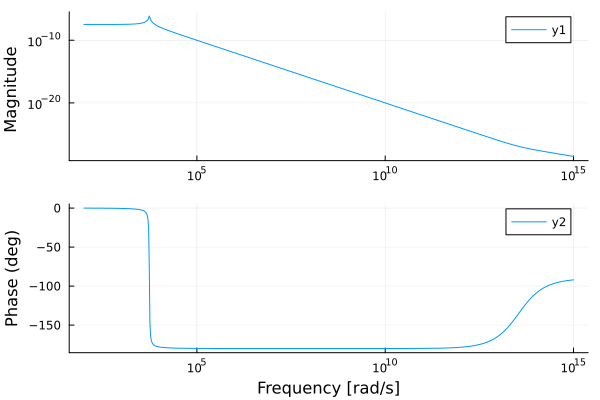

In [93]:
bodeplot(mytf)
#bodeplot(pointMassSys)
#bodeplot(mytf)

## Section 2: Double Masses-Dampers-Springs
In this section, we study a mechanism consisting of two point masses. The first mass $m_1$ is assumed to be attached to the wall with a spring having spring constant $k_{11}$ and a damper with damping constant $d_{11}$. The second mass is assumed to be attached at two locations. First, the mass $m_2$ is assumed to be attached to the wall with a spring having spring constant $k_{22}$ and a damper with damping constant $d_{22}$. Second, the mass $m_2$ is assumed to be attached to the mass $m_1$ with a spring having spring constant $k_{12}$ and a damper with damping constant $d_{12}$. 

Let $x(t)$ and $\dot{x}(t)$ denote the position and speed of point mass $m_1$ at time $t$, respectively. Similarly, let $y(t)$ and $\dot{y}(t)$ denote the position and the speed of point mass $m_2$ at time $t$, respectively. The variable $x(t)$ is the variable to be observed while $y(t)$ is the hidden variable. The mass $m_1$ and $m_2$ have external excitation $F(t)$ and $0$, respectively.  

Our goal here is to extend the previous analysis. 

### Equations of Motion in Time Domain
$$
m_1 \, \ddot{x} = -k_{11} \, x - k_{12} \, (x-y) 
                  -d_{11} \, \dot{x} - d_{12} \, (\dot{x}-\dot{y}) + F_0(t) \\
m_2 \, \ddot{y} = -k_{22} \, y - k_{21} \, (y -x) 
                  -d_{11} \, \dot{y} - d_{21} \, (\dot{y}-\dot{x})
$$

### Time-Domain Representation  
The mass matrix $M$ is given by $M = \begin{pmatrix} m_1 & 0 \\ 0 & m_2 \end{pmatrix}$. The mass matrix $M$ is thus diagonal.

The stiffness matrix $K$ is given by  
$K = \begin{pmatrix} k_{11} + k_{12} & -k_{12} \\ -k_{21} & k_{22}+k_{21} \end{pmatrix}$. The stiffness matrix is thus symmetric. The off-diagonal contributions introduce cross-coupling between the masses $m_1$ and $m_2$.  

The damping matrix $D$ is given by $D = \begin{pmatrix} d_{11} + d_{12} & -d_{12} \\ -d_{21} & d_{22}+d_{21}\end{pmatrix}$. Cross-coupling is agian introduced. 

Then equations of motion in matrix-vector form become  
$$ M \, \begin{pmatrix} \ddot{x}(t) \\ \ddot{y}(t) \end{pmatrix}
   + D \, \begin{pmatrix} \dot{x}(t) \\ \dot{y}(t) \end{pmatrix}
   + K \, \begin{pmatrix} x(t) \\ y(t) \end{pmatrix}
   = \begin{pmatrix} F_0(t) \\ 0 \end{pmatrix}$$
supplied with initial conditions. 

### State-Space Representation

In [86]:
m1 = 1; m2 = 2;    # value of point-masses 
M = [m1 0; 0 m2];  # mass matrix 
k11 = 2; k22 = 3; k12 = 1; k21 = k12;   # stiffness coefficients 
K = [k11+k12 -k12; -k21 k22+k21];       # stiffness matrix 
d11 = 2; d22 = 3; d12 = 1; d21 = k12;   # damping coefficients;
D = 1e-6*[d11+d12 -d12; -d21 d22+d21];  # stiffness matrix
F0 = 1; G0 = 2; 
A = [0 0 1 0; 0 0 0 1; M\K M\D];
B = [0 0; 0 0; F0 0; 0 G0]; 
C = [1 0 0 0; 0 1 0 0 ]; # select position of mass m_1 as observable
DD = [0 0 ; 0 0];  
twoMassSys = ss(A,B,C,DD)

StateSpace{Continuous, Float64}
A = 
  0.0   0.0   1.0      0.0
  0.0   0.0   0.0      1.0
  3.0  -1.0   3.0e-6  -1.0e-6
 -0.5   2.0  -5.0e-7   2.0e-6
B = 
 0.0  0.0
 0.0  0.0
 1.0  0.0
 0.0  2.0
C = 
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
D = 
 0.0  0.0
 0.0  0.0

Continuous-time state-space model

In [87]:
?ss

search: @s_str set_zero_subnormals ss ssrand ssdata isspace issubset issticky



```
sys = ss(A, B, C, D)      # Continuous
sys = ss(A, B, C, D, Ts)  # Discrete
```

Create a state-space model `sys::StateSpace{TE, T}` with matrix element type `T` and TE is `Continuous` or `<:Discrete`.

This is a continuous-time model if `Ts` is omitted. Otherwise, this is a discrete-time model with sampling period `Ts`.

`D` may be specified as `0` in which case a zero matrix of appropriate size is constructed automatically.  `sys = ss(D [, Ts])` specifies a static gain matrix `D`.

To associate names with states, inputs and outputs, see [`named_ss`](https://juliacontrol.github.io/RobustAndOptimalControl.jl/dev/#Named-systems).


In [88]:
mytf = tf(twoMassSys)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
Input 1 to output 1
   4.440892098500626e-16s^3 + 1.0000000000000049s^2 - 2.000000002944091e-6s - 2.0000000000000107
----------------------------------------------------------------------------------------------------
1.0s^4 - 4.999999998478444e-6s^3 - 4.999999999994502s^2 + 1.0999999998873022e-5s + 5.500000000000006

Input 1 to output 2
 1.1102230246251565e-15s^3 + 3.552713678800501e-15s^2 - 5.000000058430487e-7s - 0.5000000000000089
----------------------------------------------------------------------------------------------------
1.0s^4 - 4.999999998478444e-6s^3 - 4.999999999994502s^2 + 1.0999999998873022e-5s + 5.500000000000006

Input 2 to output 1
 -2.220446049250313e-15s^3 + 8.881784197001252e-16s^2 - 1.9999999998354667e-6s - 2.0000000000000044
----------------------------------------------------------------------------------------------------
1.0s^4 - 4.999999998478444e-6s^3 - 4.999999999994502s^2 + 1.099999

In [89]:
mytf[1]

LoadError: Must specify 2 indices to index TransferFunction model

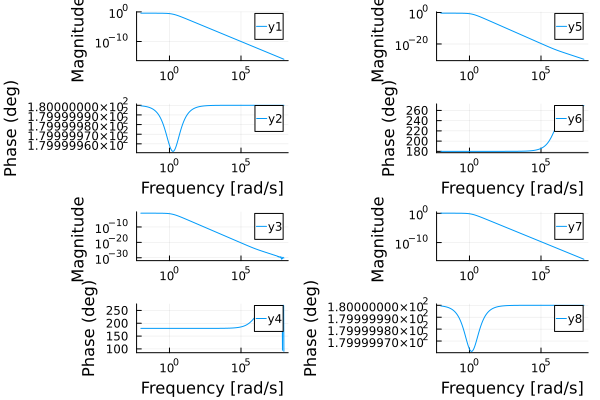

In [90]:
freqrange = Vector[1e-3:10:1e4]
bodeplot(twoMassSys; plotphase=true, freqrange)